# Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)

In this series we will build a model that will guess the emotion of a person from a facial expression. The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

Take a look at the next chapters:
- [Emotion_Classification_from_Faces_with_CNN_Part_1](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch)
- [Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)

This first notebook will focus on selecting the datasets, cleaning the data, and performing Exploratory Data Analysis (EDA). The output of this first part will be pickle files with the data that will be used in the second notebook, which will be focused on Feature Engineering.

Without further ado, let's go!

## Table of contents

1. [Loading the libraries](#loading-the-data)
2. [Loading the data](#loading-the-libraries)
3. [Balancing classes with data augmentation](#balancing-classes-with-data-augmentation)
4. [Data sources](#data-sources)

## Loading the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os,cv2
import pickle
import random
from hashlib import md5

from PIL import Image
import torch
from torchvision import transforms

## Loading the data

### About the data

The datasets were loaded by different sources and mixed together, to guarantee a diverse pool of style, etnicities, genders, and angles. This will help in preventing overfitting. When dealing with big datasets for images of facial expressions, we might encounter several challenges:

1. For example, there may be misplaced images, in the sense that images representing an emotion might have been added to the incorrect folder. Since the datset contains thousands of images, it is not possible to check them all for correctness.
2. Another problem is mixed emotions. Some images may contain mixed emotions instead of pure emotions (e.g., fear + surprise, happiness + surprise), and this may confuse the algorithm in the training phase.
3. Some facial expressions, especially when represented by actors, may not look genuine for what concerns microexpressions. Therefore, the algorithm will look at fake and genuine emotion representations as the same.

The first two challenges can be mitigated by using large datasets, as soon as most of the images are correctly labeled and contain pure emotions. The last challenge can be successfully solved by taking this generic model and training another model on top that distinguishes genuine from fake emotions. To do so though, genuine and fake emotions would need to be labelled accordingly.

We want to load and label the images acording to their respective directories. The images will also be converted in a 48x48 pixel format in grainscale to reduce dimensionality. Indeed colors are not as significant as facial expression in emotion recognition, and they can be removed, then dividing the number of dimensions by 3. After loading the images, we save the labeled dataset into a pickle file, so we can retrieve it in the future without having to load the images again.

In [19]:
# Define paths
data_path = "faces_emotions_data"
data_larger_path = "faces_emotions_data_larger"

# Define class labels
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', "Surprise"]

We are creating three different paths to two different datasets. One is larger than the other, but is also contains some images of dubbious quality. Some images are not from photograps, and other images are labeled incorrectly. However, it was possible only to check a few of those images manually, therefore, before discarding the large datasets, it is better to load it, test some of the images, and see what is the number of items for each label. The third dataset starts from the smaller dataset. but without any duplicate. We remove duplicates based on hash code. Two images with the same hash code are very likely to have the same content. Even if we found two different images with the same hash code, all the other images we have checked were duplicates, and removing a few images is a fair price to pay to remove many duplicates that may over represent certain faces.

In [ ]:
# Helper function to load images, label them, and save to pickle files
def load_label_and_pickle_images(data_path, class_labels, output_file):
    img_data_list = []
    img_labels_list = []

    for label in class_labels:
        img_dir = os.path.join(data_path, label)
        img_list = os.listdir(img_dir)
        print(f'The images of the dataset {label} were loaded successfully\n')
        
        for img in img_list:
            img_path = os.path.join(img_dir, img)
            input_img = cv2.imread(img_path)
            
            if input_img is None:
                print(f'Failed to load image: {img_path}')
                continue
            
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize = cv2.resize(input_img, (48, 48))
            img_data_list.append(input_img_resize)
            img_labels_list.append(label)
    
    # Convert to numpy array and normalize
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data / 255.0

    # Convert labels to numpy array
    img_labels = np.array(img_labels_list)

    # Save images and labels to a pickle file
    with open('output_file.pkl', 'wb') as f:
        pickle.dump((img_data, img_labels), f)

    print(f'{output_file} has been saved with shape {img_data.shape} and labels shape {img_labels.shape}')

In [20]:
#Execute Function
output_file = 'images_labels.pkl'
load_label_and_pickle_images(data_path, class_labels, output_file)

The images of the dataset Anger were loaded successfully

The images of the dataset Contempt were loaded successfully

The images of the dataset Disgust were loaded successfully

The images of the dataset Fear were loaded successfully

The images of the dataset Happiness were loaded successfully

The images of the dataset Neutral were loaded successfully

The images of the dataset Sadness were loaded successfully

The images of the dataset Surprise were loaded successfully

images_labels.pkl has been saved with shape (37615, 48, 48) and labels shape (37615,)


In [21]:
#Execute Function
data_larger = "faces_emotions_data_larger"
output_file = 'images_labels_larger.pkl'
load_label_and_pickle_images(data_path, class_labels, output_file)

The images of the dataset Anger were loaded successfully

The images of the dataset Contempt were loaded successfully

The images of the dataset Disgust were loaded successfully

The images of the dataset Fear were loaded successfully

The images of the dataset Happiness were loaded successfully

The images of the dataset Neutral were loaded successfully

The images of the dataset Sadness were loaded successfully

The images of the dataset Surprise were loaded successfully

images_labels_larger.pkl has been saved with shape (37615, 48, 48) and labels shape (37615,)


In [12]:
# Function to load images, label them, and save to pickle files
def load_label_and_pickle_images(data_path, class_labels):
    img_data_list = []
    img_labels_list = []

    img_hash_dict = {}  # To keep track of image hashes across all folders

    for label in class_labels:
        img_dir = os.path.join(data_path, label)
        img_list = os.listdir(img_dir)
        print(f'The images of the dataset {label} were loaded successfully\n')

        for img in img_list:
            img_path = os.path.join(img_dir, img)

            input_img = cv2.imread(img_path)
            
            if input_img is None:
                print(f'Failed to load image: {img_path}')
                continue
            
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize = cv2.resize(input_img, (48, 48))

            # Compute hash of the image
            img_hash = md5(input_img_resize).hexdigest()

            if img_hash in img_hash_dict:
                print(f'Removing duplicate image: {img_path} (duplicate of {img_hash_dict[img_hash]})')
                continue  # Skip adding this duplicate image
            else:
                img_hash_dict[img_hash] = img_path

            img_data_list.append(input_img_resize)
            img_labels_list.append(label)

    # Convert to numpy array and normalize
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data / 255.0

    # Convert labels to numpy array
    img_labels = np.array(img_labels_list)

    # Save images and labels to a pickle file
    with open('images_labels_no_duplicates.pkl', 'wb') as f:
        pickle.dump((img_data, img_labels), f)

    print(f'images_labels_no_duplicates.pkl has been saved with shape {img_data.shape} and labels shape {img_labels.shape}')

# Execute the function
data_path = "faces_emotions_data"
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
load_label_and_pickle_images(data_path, class_labels)

The images of the dataset Anger were loaded successfully

Removing duplicate image: faces_emotions_data\Anger\1211.jpg (duplicate of faces_emotions_data\Anger\10315.jpg)
Removing duplicate image: faces_emotions_data\Anger\12262.jpg (duplicate of faces_emotions_data\Anger\107.jpg)
Removing duplicate image: faces_emotions_data\Anger\13148.jpg (duplicate of faces_emotions_data\Anger\11286.jpg)
Removing duplicate image: faces_emotions_data\Anger\13402.jpg (duplicate of faces_emotions_data\Anger\11286.jpg)
Removing duplicate image: faces_emotions_data\Anger\14096.jpg (duplicate of faces_emotions_data\Anger\11813.jpg)
Removing duplicate image: faces_emotions_data\Anger\14344.jpg (duplicate of faces_emotions_data\Anger\1122.jpg)
Removing duplicate image: faces_emotions_data\Anger\1462.jpg (duplicate of faces_emotions_data\Anger\12025.jpg)
Removing duplicate image: faces_emotions_data\Anger\15138.jpg (duplicate of faces_emotions_data\Anger\107.jpg)
Removing duplicate image: faces_emotions_data

Now that the images are loaded, we need to verify that they have been labeled correctly.

In [2]:
# Helper function to load the pickled data and verify the images
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Randomly pick and plot one image from each class
    plt.figure(figsize=(16, 8))

    unique_labels = np.unique(img_labels)
    for idx, label in enumerate(unique_labels):
        # Get all images for the current label
        label_images = img_data[img_labels == label]

        # Randomly select one image
        random_image = random.choice(label_images)

        plt.subplot(2, 4, idx + 1)
        plt.imshow(random_image, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

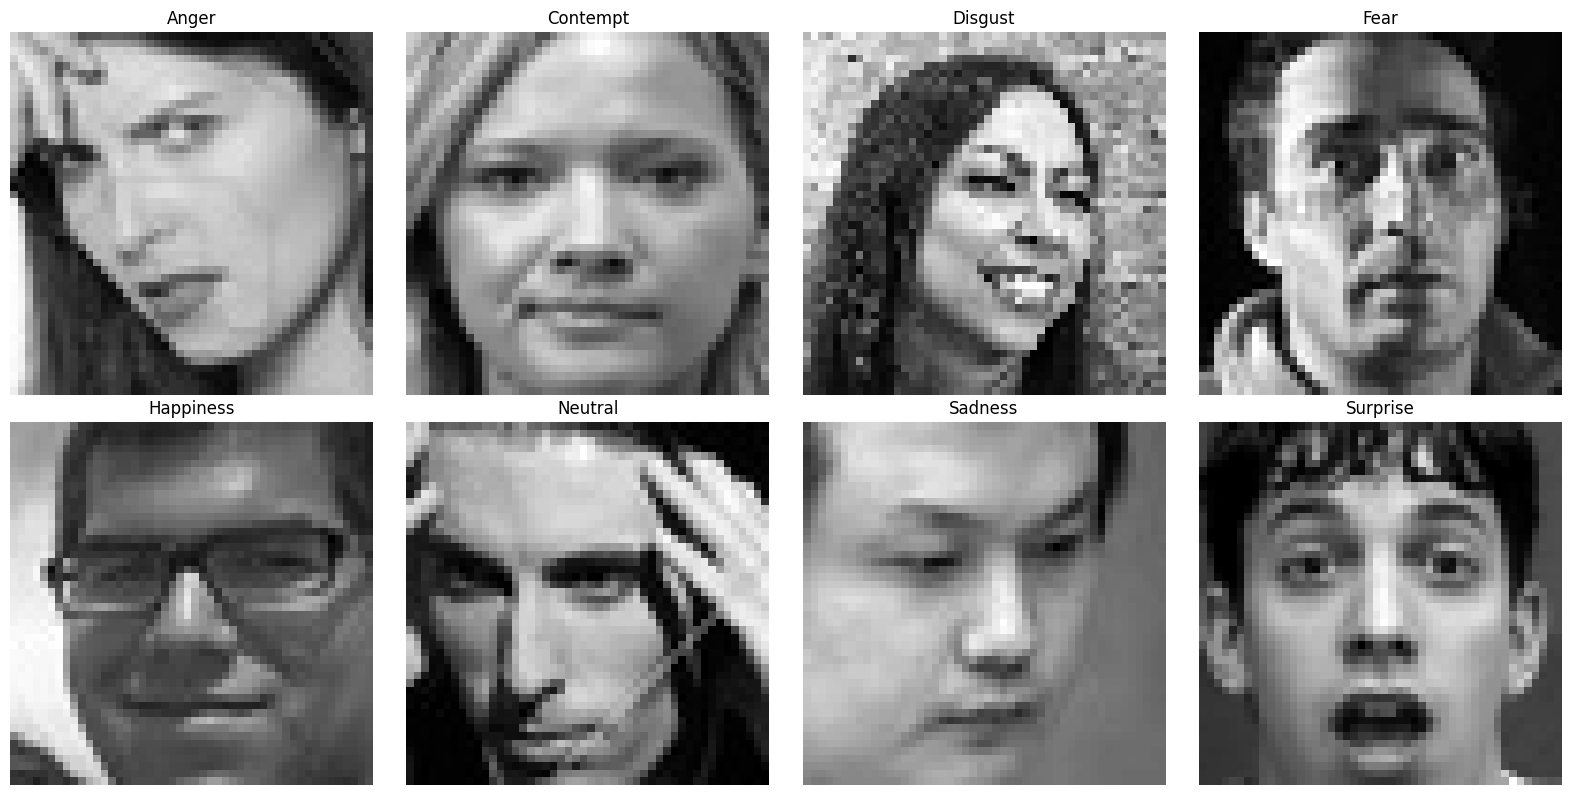

In [12]:
# Specify the input dataset file
dataset_file = 'images_labels.pkl'

# Execute the verification function
verify_images(dataset_file)

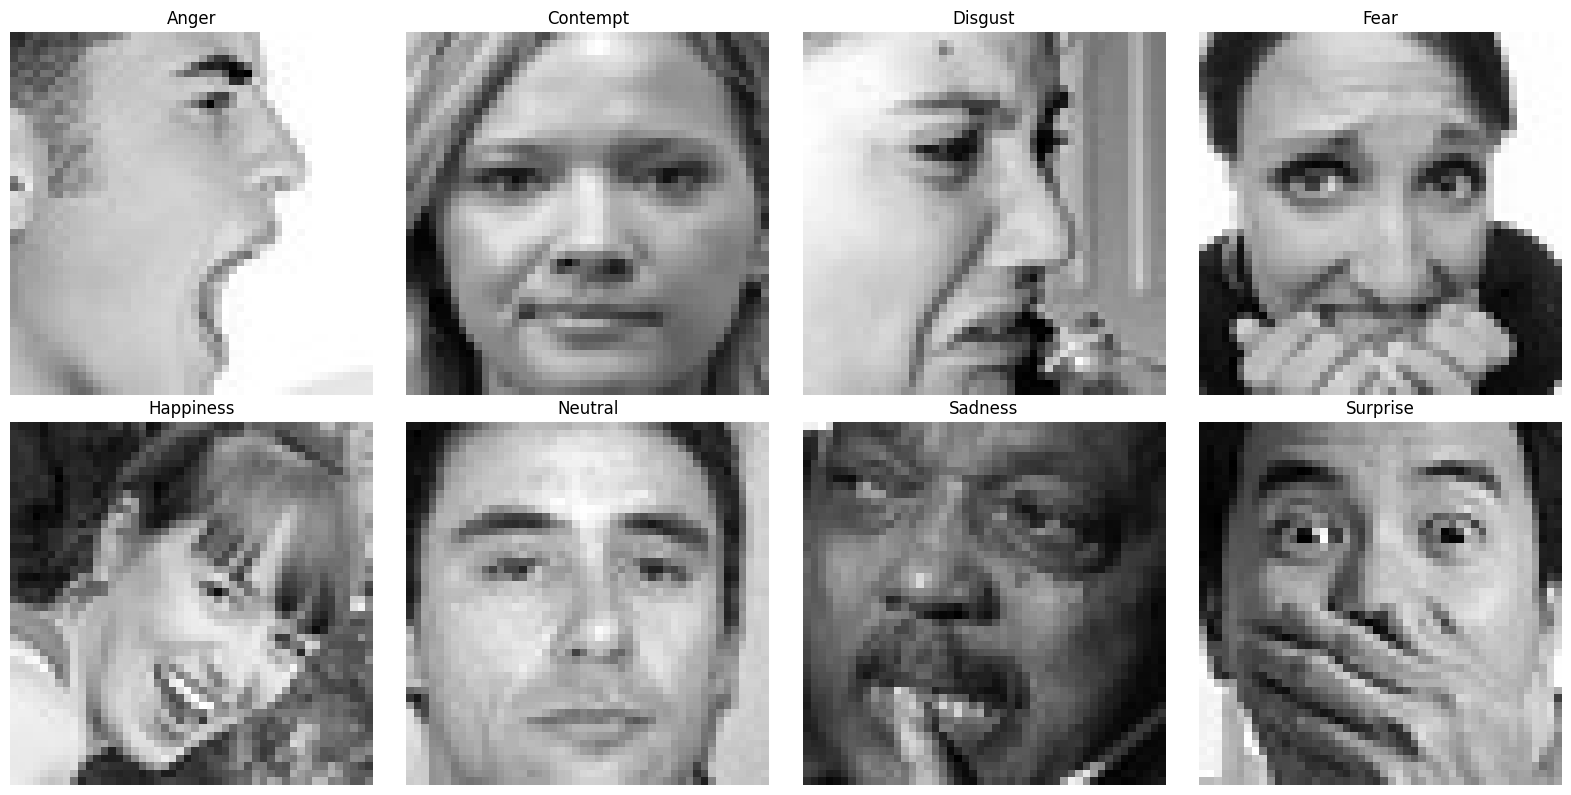

In [13]:
# Specify the input dataset file
dataset_file = 'images_labels_larger.pkl'

# Execute the verification function
verify_images(dataset_file)

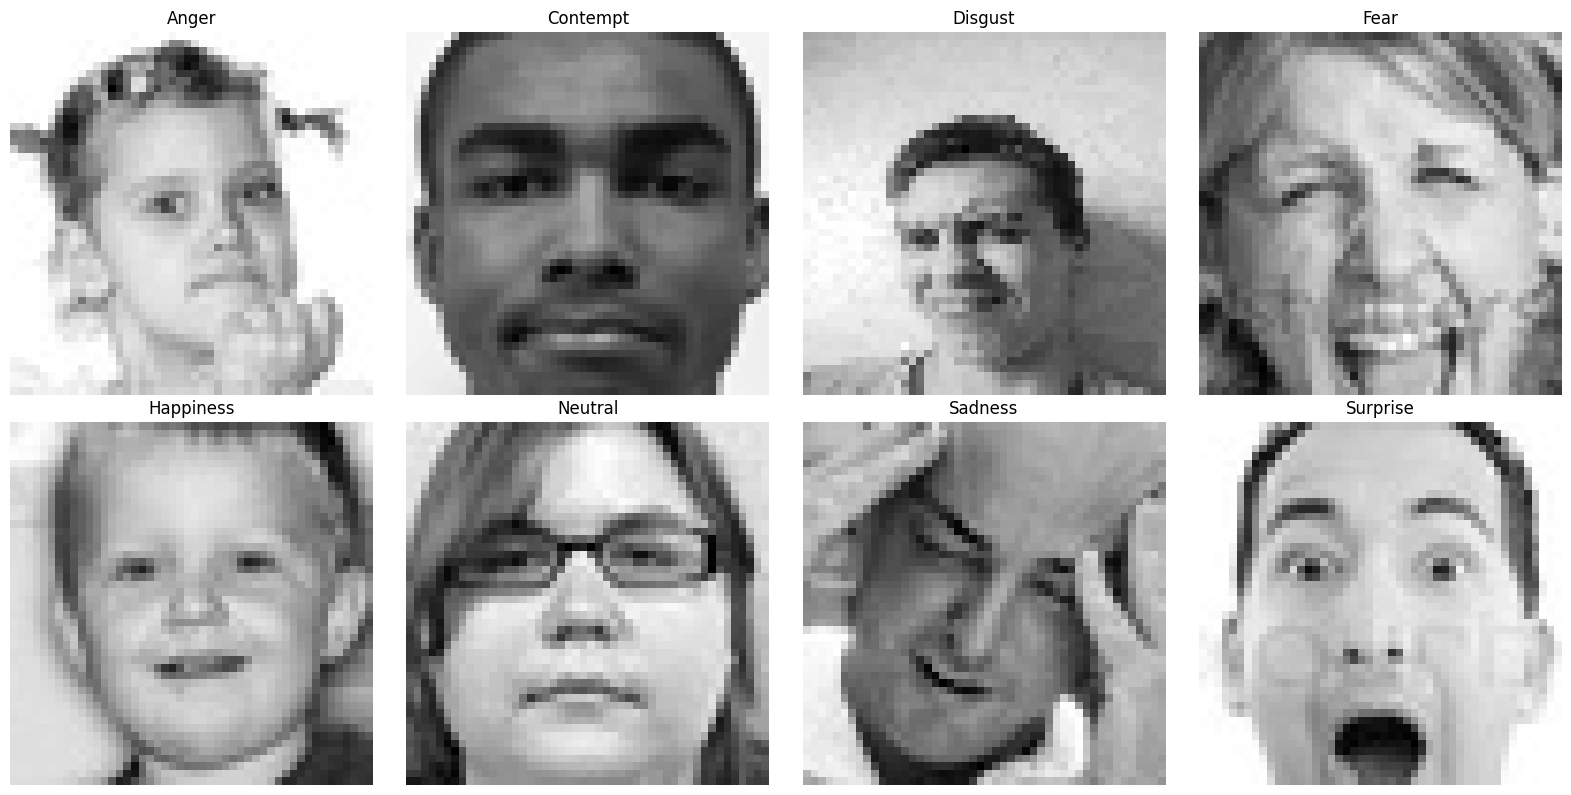

In [14]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

# Execute the verification function
verify_images(dataset_file)

The images have been loaded in the correct format, now we need to see how many images we have for each category.

In [3]:
#Helper function to cont and plot the items for each label
def count_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

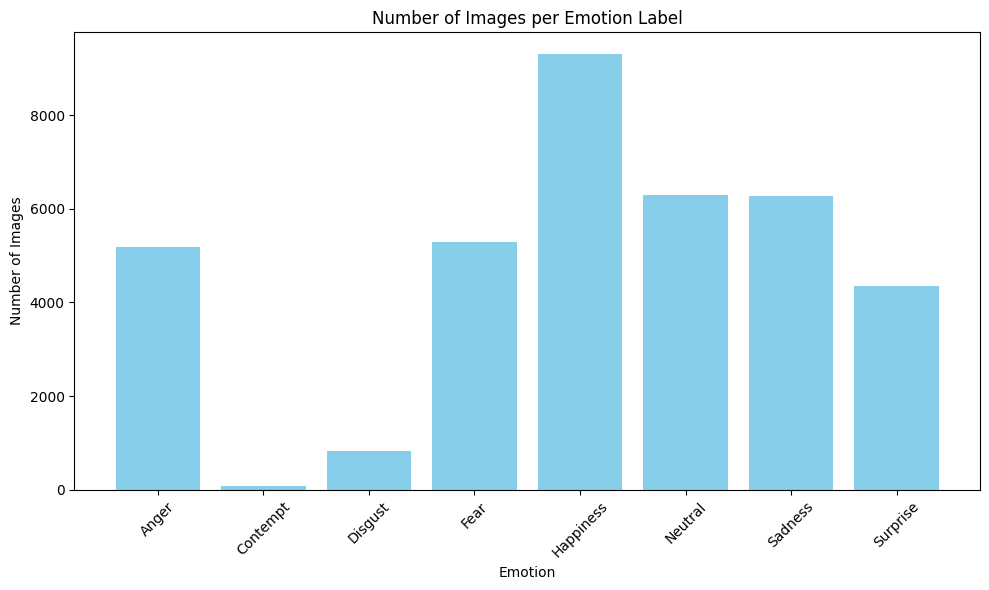

In [15]:
# Specify the input dataset file
dataset_file = 'images_labels.pkl'

# Execute the verification function
count_items_in_classes(dataset_file)

Anger, fear, neutral, sadness, surprise are at similar levels. However, we have only a few images for contempt and disgust, and too many images for happiness. We need to solve the data imbalance to prevent missclassification of images.

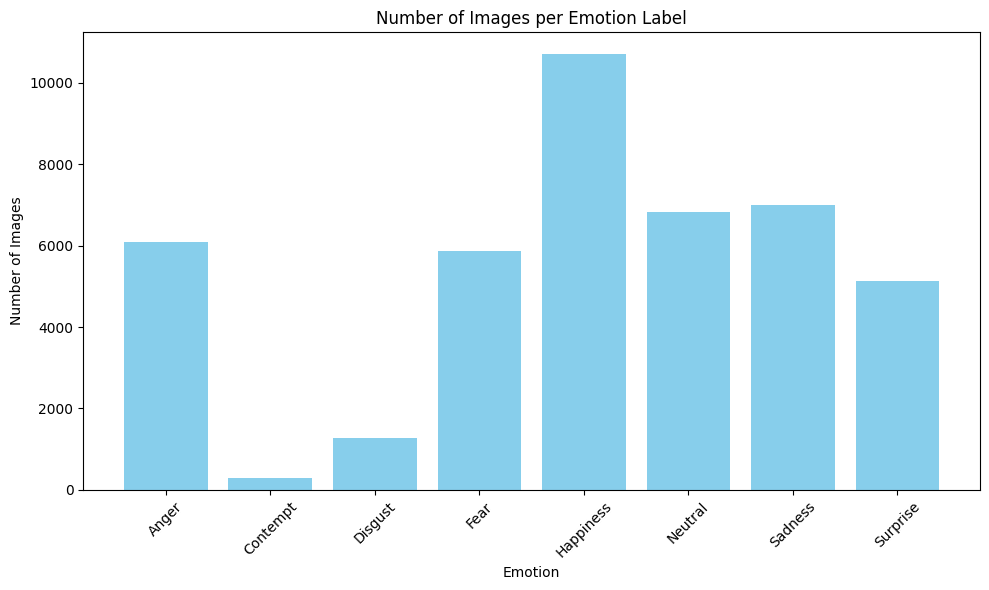

In [16]:
# Specify the input dataset file
dataset_file = 'images_labels_larger.pkl'

# Execute the verification function
count_items_in_classes(dataset_file)

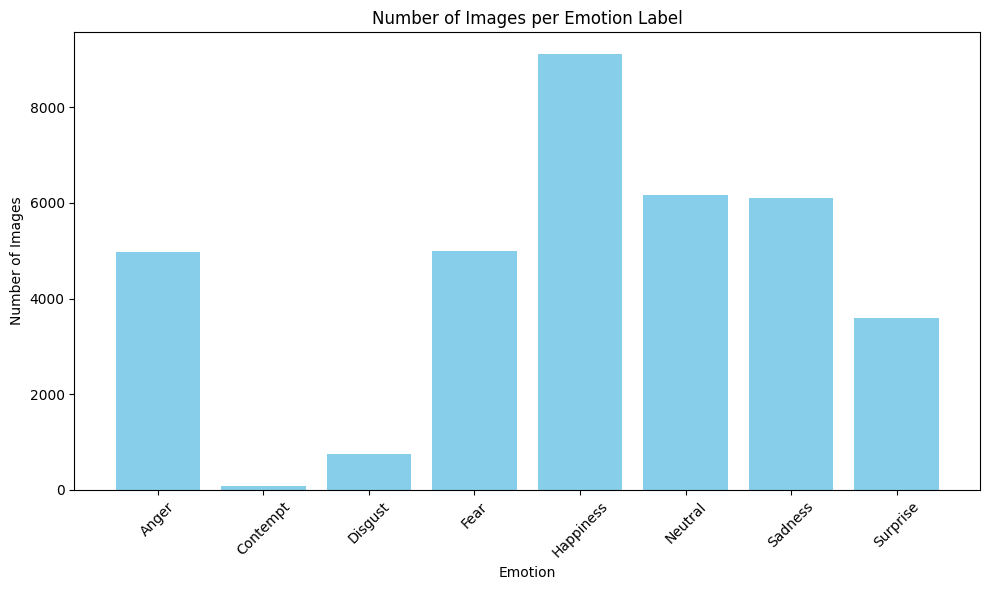

In [6]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

# Execute the verification function
count_items_in_classes(dataset_file)

It looks like the larger dataset has some missclassified images, and it doesn't solve the problem with the proportion of the items beloning to different labels. Therefore we are going to use the smaller dataset without duplicates.

## Balancing classes with data augmentation

As said, to balance the classes we are going to perform data augmentation. This process consists in randomly copying images (in this cases images appartaining to underrepresented classes), by adding noise such as rotation, cropping, blurring, and changing the intesity of colors or contrast. In this case, since we still need to detect the emotion represented by each face, we cannot alter the images too much, such as by adding heavy rotations or contrast, because it would impair the ability to recognize such faces.

In [30]:
# Define the data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    #transforms.ColorJitter(contrast=0.1, saturation=0.1, brightness=0.1, hue=0.1), #we remove colorjitter because it can impair the display of microexpressions
])

def augment_images(img_data, target_count, label):
    augmented_images = []
    while len(augmented_images) + len(img_data) < target_count:
        for img in img_data:
            if len(augmented_images) + len(img_data) >= target_count:
                break
            img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
            augmented_img = data_transforms(img_pil)  # Apply transforms
            augmented_img = np.array(augmented_img).astype('float32') / 255.0  # Normalize back to 0-1 range
            augmented_images.append(augmented_img)
        print(f'{label}: {len(augmented_images)} augmented images generated so far')
    return np.array(augmented_images)

def balance_dataset(input_pickle_file, output_pickle_file):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Combine images and labels into a dictionary
    img_data_dict = {label: [] for label in set(img_labels)}
    for img, label in zip(img_data, img_labels):
        img_data_dict[label].append(img)

    # Find the maximum class size
    max_class_size = max(len(img_list) for img_list in img_data_dict.values())

    # Balance the dataset
    balanced_img_data_dict = {}

    for label, img_list in img_data_dict.items():
        img_list = np.array(img_list).astype('float32')
        print(f'Processing {label}, {len(img_list)} images')
        if len(img_list) < max_class_size:
            augmented_imgs = augment_images(img_list, max_class_size, label)
            balanced_img_data_dict[label] = np.concatenate((img_list, augmented_imgs), axis=0)
        else:
            balanced_img_data_dict[label] = img_list

        with open(f'{label}_balanced_images.pkl', 'wb') as f:
            pickle.dump(balanced_img_data_dict[label], f)
        print(f'{label}_balanced_images.pkl has been saved with shape {balanced_img_data_dict[label].shape}')

    # Save the entire balanced dataset into a single pickle file
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(balanced_img_data_dict, f)
    print(f'{output_pickle_file} has been saved')

In [31]:
input_pickle_file = 'images_labels_no_duplicates.pkl'
output_pickle_file = 'balanced_images_labels.pkl'
balance_dataset(input_pickle_file, output_pickle_file)

Processing Neutral, 6155 images
Neutral: 2956 augmented images generated so far
Neutral_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Sadness, 6100 images
Sadness: 3011 augmented images generated so far
Sadness_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Surprise, 3599 images
Surprise: 3599 augmented images generated so far
Surprise: 5512 augmented images generated so far
Surprise_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Happiness, 9111 images
Happiness_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Anger, 4977 images
Anger: 4134 augmented images generated so far
Anger_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Fear, 5003 images
Fear: 4108 augmented images generated so far
Fear_balanced_images.pkl has been saved with shape (9111, 48, 48)
Processing Disgust, 743 images
Disgust: 743 augmented images generated so far
Disgust: 1486 augmented images gene

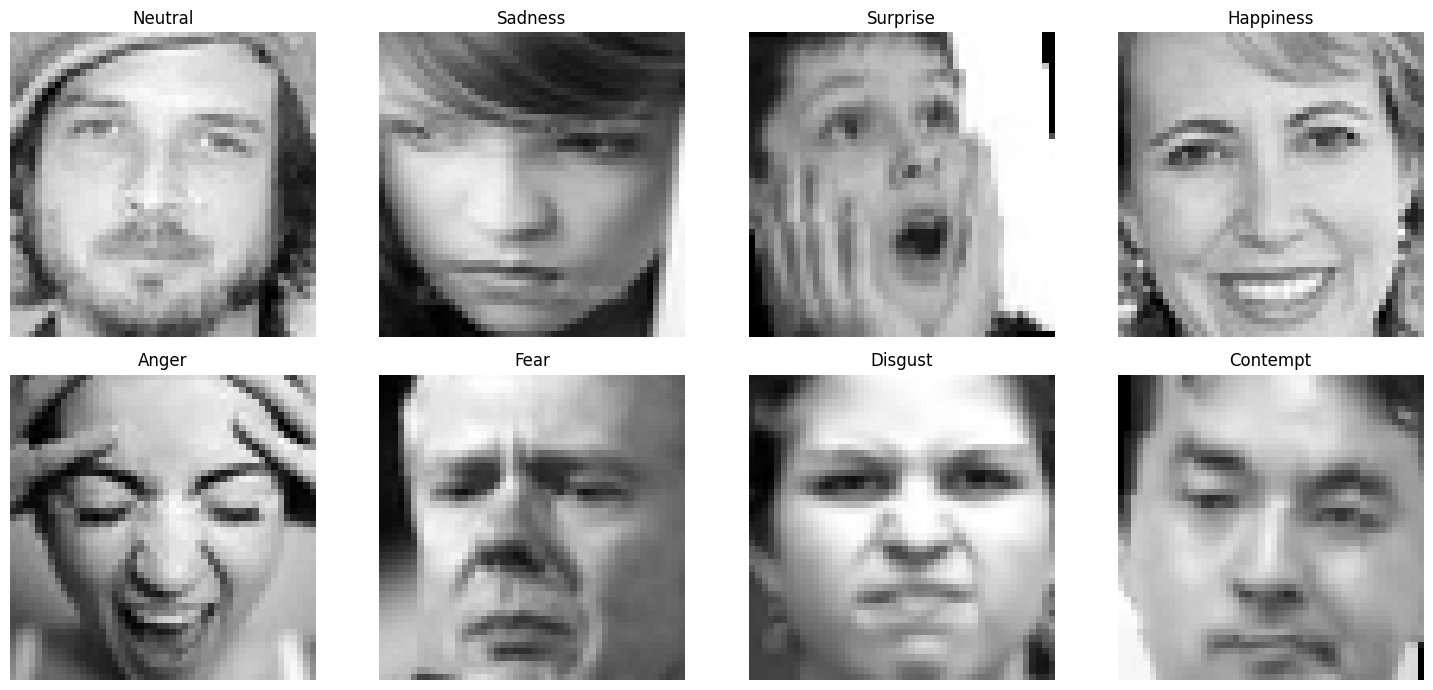

In [32]:
# Visualize a few samples to ensure the data augmentation worked correctly
with open(output_pickle_file, 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, label in enumerate(balanced_img_data_dict.keys()):
    img_data = balanced_img_data_dict[label]
    img_idx = random.randint(0, len(img_data) - 1)
    img = img_data[img_idx]
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

It woeked correctly, now let's check the number of items for each category.

In [34]:
def count_items_in_classes_2(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Count the number of items in each class
    for label, img_list in balanced_img_data_dict.items():
        print(f'{label}: {len(img_list)} images')

In [33]:
# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the verification function
count_items_in_classes_2(dataset_file)

Neutral: 9111 images
Sadness: 9111 images
Surprise: 9111 images
Happiness: 9111 images
Anger: 9111 images
Fear: 9111 images
Disgust: 9111 images
Contempt: 9111 images


Each label has now the same amount of items.

Let's check the properties of the datasets.

In [35]:
# Load the data from the pickle file
with open('images_labels_no_duplicates.pkl', 'rb') as f:
    img_data, img_labels = pickle.load(f)

# Print out some basic information about the data
print(f'Loaded data shape: {img_data.shape}')
print(f'Loaded labels shape: {img_labels.shape}')
print(f'Unique labels: {set(img_labels)}')


Loaded data shape: (35761, 48, 48)
Loaded labels shape: (35761,)
Unique labels: {'Neutral', 'Sadness', 'Surprise', 'Happiness', 'Anger', 'Fear', 'Disgust', 'Contempt'}


In [36]:
def inspect_balanced_dataset(file_path):
    # Load the balanced dataset
    with open(file_path, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)
    
    # Initialize lists to collect all images and labels
    all_images = []
    all_labels = []

    # Iterate through the dictionary to collect data
    for label, img_list in balanced_img_data_dict.items():
        all_images.extend(img_list)
        all_labels.extend([label] * len(img_list))
    
    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    # Print the required information
    print(f'Loaded data shape: {all_images.shape}')
    print(f'Loaded labels shape: {all_labels.shape}')
    print(f'Unique labels: {set(all_labels)}')

# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the inspection function
inspect_balanced_dataset(dataset_file)


Loaded data shape: (72888, 48, 48)
Loaded labels shape: (72888,)
Unique labels: {'Neutral', 'Sadness', 'Happiness', 'Anger', 'Fear', 'Surprise', 'Contempt', 'Disgust'}


Now we have 72888 images, a good number of itmes to train our deep neural networks.

Se you in the next notebooks, when we will fine tune the hyperparameters, build and train different models, and evaluate them.

Take a look at the next chapters:
- [Emotion_Recognition_from_Faces_with_CNN_Pytorch](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch)
- [Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)

## Data sources

Even if we didn't end up using all of them, we want to thank the different sources of the dataset we downloaded for this project:
1. https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge
2. https://www.kaggle.com/datasets/shawon10/ckplus
3. https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition
4. https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition
5. https://www.kaggle.com/datasets/cesarron/ecuadorian-facial-expression-efe-dataset
6. https://www.kaggle.com/datasets/nabilsherif/facial-emotions
7. https://www.kaggle.com/datasets/nabilsherif/facial-emotions-recognition-dataset
8. https://www.kaggle.com/datasets/mh0386/facial-emotion